# **Heart Rate Variability (HRV) with NeuroKit2**

## Initialization

In [84]:
#!pip install neurokit2 

import neurokit2 as nk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob

In [85]:
data_path = 'C:/Users/asnag/OneDrive - Università degli Studi di Milano/LT/LT MATLAB/Raw/T0/'
d_raw = glob.glob(data_path+'*raw.csv')
d_event = glob.glob(data_path+'*event.csv')
d_event_name = glob.glob(data_path+'*event_name.csv')

In [86]:
len(d_raw), len(d_event), len(d_event_name)

(10, 10, 10)

In [87]:
fs = 256

## Divide into segments

Divide into segment and select the ECG channels

In [88]:
A , B, C = [], [], []

for n in range(len(d_raw)):
    raw = np.loadtxt(d_raw[n], delimiter=',')
    event = np.loadtxt(d_event[n], delimiter=',', dtype=int)
    #np.loadtxt(event_name[n], delimiter=',', dtype=str)

    A.append(raw[event[0,0]:event[0,0] + fs*5*60, :2])
    B.append(raw[event[2,0]:event[2,0] + fs*12*60, :2])
    C.append(raw[event[4,0]:event[4,0] + fs*5*60, :2])

## Preprocessing

### Quality assesment

Select the best ECG during LT

In [89]:
q = []

for n in range(len(B)):
    c1 = nk.ecg_clean(B[n][:,0], sampling_rate=fs, method='neurokit')
    c2 = nk.ecg_clean(B[n][:,1], sampling_rate=fs, method='neurokit')

    s1 = np.mean(nk.ecg_quality(c1, rpeaks=None, sampling_rate=fs, method='averageQRS'))
    s2 = np.mean(nk.ecg_quality(c2, rpeaks=None, sampling_rate=fs, method='averageQRS'))

    if s1>s2:
        q.append([0])
    else:
        q.append([1])

q = np.squeeze(np.array(q))

### ECG clean and RR series

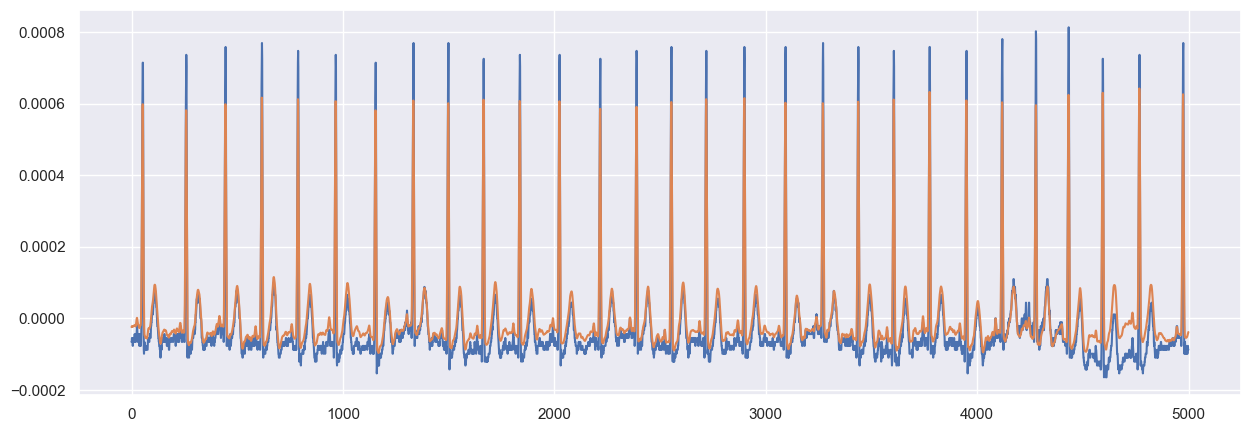

In [90]:
plt.figure(figsize=(15,5))
plt.plot(A[0][:5000,1])
plt.plot(nk.ecg_clean(A[0][:5000,1], sampling_rate=fs, method='neurokit'))
plt.show()

In [96]:
hrv_a = pd.DataFrame()

for n in range(len(A)):
    rr = nk.ecg_clean(A[n][:,q[n]], sampling_rate=fs, method='neurokit')
    _, rr = nk.ecg_peaks(rr, sampling_rate=fs, method='neurokit', correct_artifacts=True)

    hrv_a = pd.concat((hrv_a, nk.hrv(rr, sampling_rate=fs)))

hrv_a.describe()

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
count,10.000000,10.000000,10.000000,10.000000,0.0,0.0,0.0,0.0,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,596.639465,44.385904,15.561476,41.530666,NaN,NaN,NaN,NaN,23.320723,23.343221,...,1.131579,5.239772,0.838218,1.526117,1.394913,2.027859,1.518970,1.552318,2.545186,0.638964
std,69.314441,14.855855,6.583005,14.111015,NaN,NaN,NaN,NaN,10.837400,10.851253,...,0.342082,0.416078,0.175362,0.106092,0.028476,0.251333,0.238335,0.119495,0.499365,0.135507
min,470.088935,30.559151,8.118818,27.490990,NaN,NaN,NaN,NaN,13.676051,13.689665,...,0.417835,4.871160,0.479888,1.331487,1.351446,1.489640,1.019530,1.391847,1.931088,0.424644
25%,559.353252,33.655337,11.541843,31.442929,NaN,NaN,NaN,NaN,16.547428,16.561770,...,1.113815,4.966808,0.755499,1.465444,1.374273,2.022695,1.429055,1.462208,2.247471,0.527930
50%,583.560439,39.561728,14.152649,37.673498,NaN,NaN,NaN,NaN,20.078512,20.091407,...,1.199364,5.077380,0.883320,1.528460,1.392198,2.115257,1.617012,1.578592,2.537643,0.631253
75%,663.415260,46.461230,16.778712,44.314621,NaN,NaN,NaN,NaN,23.440312,23.464903,...,1.271167,5.407878,0.937117,1.606663,1.409251,2.179927,1.704690,1.612887,2.784809,0.769777
max,684.937643,75.439288,27.021397,71.025413,NaN,NaN,NaN,NaN,44.627797,44.677587,...,1.618049,6.049158,1.057794,1.679168,1.446133,2.266670,1.714002,1.740030,3.605503,0.807791


In [97]:
hrv_b = pd.DataFrame()

for n in range(len(B)):
    rr = nk.ecg_clean(B[n][fs*2*60:,q[n]], sampling_rate=fs, method='neurokit')
    _, rr = nk.ecg_peaks(rr, sampling_rate=fs, method='neurokit', correct_artifacts=True)

    hrv_b = pd.concat((hrv_b, nk.hrv(rr, sampling_rate=fs)))

hrv_b.describe()

c:\Users\asnag\AppData\Local\Programs\Python\Python310\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:277: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
c:\Users\asnag\AppData\Local\Programs\Python\Python310\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,0.0,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,465.384526,86.253862,50.987060,58.217714,42.892238,64.938664,NaN,NaN,63.118833,63.143919,...,0.315175,5.295083,0.334418,0.679006,0.871934,0.928037,0.690038,1.585673,2.111181,0.340637
std,63.814029,53.194892,23.192426,51.155528,25.944334,51.756129,NaN,NaN,70.681324,70.711061,...,0.180015,0.556254,0.075483,0.250767,0.265389,0.459029,0.296256,0.155585,0.309238,0.102758
min,356.554594,31.532154,18.694093,21.036449,10.627608,23.221991,NaN,NaN,10.951236,10.955072,...,0.087907,4.449195,0.178305,0.358093,0.545330,0.427086,0.318954,1.412784,1.612511,0.191619
25%,429.223741,63.477192,32.924865,29.317340,20.378462,33.577863,NaN,NaN,17.389552,17.396854,...,0.216029,4.882514,0.308781,0.559558,0.633030,0.559535,0.482800,1.458746,2.038880,0.259475
50%,470.941570,71.090524,51.759914,43.768955,41.900477,53.835477,NaN,NaN,36.309370,36.323792,...,0.251810,5.373681,0.318459,0.647076,0.877326,0.810770,0.664217,1.544615,2.113469,0.333379
75%,502.007746,97.229864,65.247006,55.507377,61.578158,63.774887,NaN,NaN,69.886949,69.912251,...,0.354518,5.591539,0.378046,0.715718,1.049318,1.140003,0.859946,1.686368,2.243198,0.408698
max,581.004486,219.914408,91.377835,193.857903,87.496780,199.773257,NaN,NaN,235.946846,236.046200,...,0.660502,6.128322,0.442334,1.272078,1.245405,1.773098,1.231351,1.828599,2.593354,0.507277


In [98]:
hrv_c = pd.DataFrame()

for n in range(len(C)):
    rr = nk.ecg_clean(C[n][:,q[n]], sampling_rate=fs, method='neurokit')
    _, rr = nk.ecg_peaks(rr, sampling_rate=fs, method='neurokit', correct_artifacts=True)

    hrv_c = pd.concat((hrv_c, nk.hrv(rr, sampling_rate=fs)))

hrv_c.describe()

c:\Users\asnag\AppData\Local\Programs\Python\Python310\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:277: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2


,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
count,10.000000,10.000000,10.000000,10.000000,0.0,0.0,0.0,0.0,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,609.917715,61.927354,39.668686,47.297447,NaN,NaN,NaN,NaN,26.963130,26.987877,...,0.916484,5.677641,0.665542,1.349314,1.287134,1.785305,1.392574,1.524919,2.035161,0.510045
std,77.460534,20.920152,12.259447,19.927781,NaN,NaN,NaN,NaN,16.532149,16.552900,...,0.302162,0.399104,0.189295,0.249522,0.068991,0.306048,0.214928,0.095185,0.300669,0.127289
min,516.205203,38.134051,25.036007,23.508952,NaN,NaN,NaN,NaN,9.206119,9.211321,...,0.526782,5.146458,0.390158,0.800849,1.125830,1.190208,1.109108,1.383184,1.705102,0.317009
25%,554.547474,49.437394,31.195803,35.553132,NaN,NaN,NaN,NaN,17.667055,17.677125,...,0.634150,5.445566,0.520311,1.221400,1.268489,1.637510,1.209153,1.448543,1.783865,0.407054
50%,597.270871,59.993505,36.552293,40.891972,NaN,NaN,NaN,NaN,22.977187,22.995873,...,0.988541,5.687995,0.650981,1.415906,1.303269,1.885092,1.397787,1.537107,2.023928,0.537506
75%,625.940319,68.736901,44.116421,56.907534,NaN,NaN,NaN,NaN,29.221872,29.248633,...,1.121305,5.881556,0.821310,1.531927,1.325471,1.981336,1.521955,1.558420,2.147716,0.618874
max,753.472222,109.951140,64.524021,90.864074,NaN,NaN,NaN,NaN,68.665890,68.742706,...,1.351609,6.496874,0.949206,1.631214,1.376003,2.170433,1.696866,1.699821,2.675623,0.656253


## Statistical Analysis

In [99]:
hrv_a = hrv_a[['HRV_MeanNN','HRV_SDNN','HRV_MedianNN','HRV_IQRNN','HRV_RMSSD','HRV_LFHF','HRV_LFn','HRV_HFn', 'HRV_SD1', 'HRV_SD2']]
hrv_b = hrv_b[['HRV_MeanNN','HRV_SDNN','HRV_MedianNN','HRV_IQRNN','HRV_RMSSD','HRV_LFHF','HRV_LFn','HRV_HFn', 'HRV_SD1', 'HRV_SD2']]
hrv_c = hrv_c[['HRV_MeanNN','HRV_SDNN','HRV_MedianNN','HRV_IQRNN','HRV_RMSSD','HRV_LFHF','HRV_LFn','HRV_HFn', 'HRV_SD1', 'HRV_SD2']]

In [100]:
import scipy
import scikit_posthocs as sp

for i in range(len(hrv_a.columns)):
    print(hrv_a.columns[i])
    print(scipy.stats.friedmanchisquare(hrv_a.iloc[:,i], hrv_b.iloc[:,i], hrv_c.iloc[:,i]))
    print(sp.posthoc_nemenyi_friedman(np.array([hrv_a.iloc[:,i], hrv_b.iloc[:,i], hrv_c.iloc[:,i]]).T))

HRV_MeanNN
FriedmanchisquareResult(statistic=15.800000000000011, pvalue=0.00037074354045908616)
          0        1         2
0  1.000000  0.01021  0.631856
1  0.010210  1.00000  0.001000
2  0.631856  0.00100  1.000000
HRV_SDNN
FriedmanchisquareResult(statistic=12.200000000000017, pvalue=0.0022428677194857843)
          0         1        2
0  1.000000  0.004967  0.01021
1  0.004967  1.000000  0.90000
2  0.010210  0.900000  1.00000
HRV_MedianNN
FriedmanchisquareResult(statistic=15.800000000000011, pvalue=0.00037074354045908616)
          0        1         2
0  1.000000  0.01021  0.631856
1  0.010210  1.00000  0.001000
2  0.631856  0.00100  1.000000
HRV_IQRNN
FriedmanchisquareResult(statistic=9.210526315789474, pvalue=0.009999070324151078)
          0         1         2
0  1.000000  0.823726  0.065303
1  0.823726  1.000000  0.014362
2  0.065303  0.014362  1.000000
HRV_RMSSD
FriedmanchisquareResult(statistic=1.4000000000000057, pvalue=0.496585303791408)
          0         1         2

### Graphs

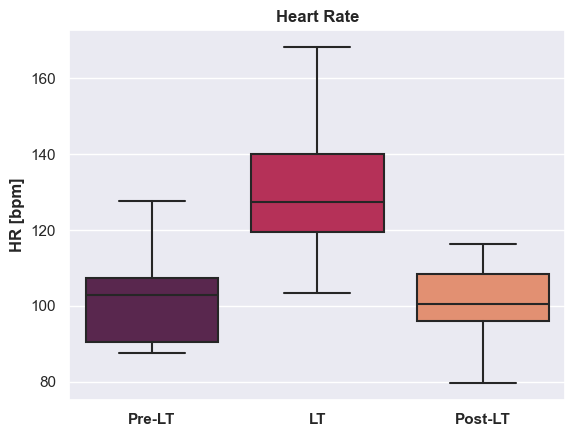

In [123]:
sns.set()
sns.boxplot([60/(hrv_a['HRV_MeanNN']/1000), 60/(hrv_b['HRV_MeanNN']/1000),60/(hrv_c['HRV_MeanNN']/1000)], palette='rocket')

plt.ylabel('HR [bpm]', weight = 'bold')
plt.title('Heart Rate', weight = 'bold')

plt.xticks([0,1,2],['Pre-LT', 'LT', 'Post-LT'], weight = 'bold')
plt.show()

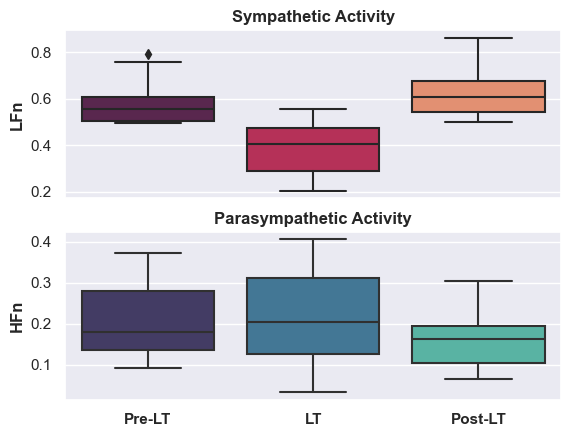

In [82]:
sns.set()
plt.tight_layout
fig, ax = plt.subplots(2,1, sharex=True)
sns.boxplot([hrv_a['HRV_LFn'],hrv_b['HRV_LFn'],hrv_c['HRV_LFn']], ax=ax[0], palette='rocket')
sns.boxplot([hrv_a['HRV_HFn'],hrv_b['HRV_HFn'],hrv_c['HRV_HFn']], ax=ax[1], palette= 'mako')

ax[0].set_ylabel('LFn', weight = 'bold')
ax[0].set_title('Sympathetic Activity', weight = 'bold')
ax[1].set_ylabel('HFn', weight = 'bold')
ax[1].set_title('Parasympathetic Activity', weight = 'bold')

ax[1].set_xticks([0,1,2],['Pre-LT', 'LT', 'Post-LT'], weight = 'bold')
plt.show()

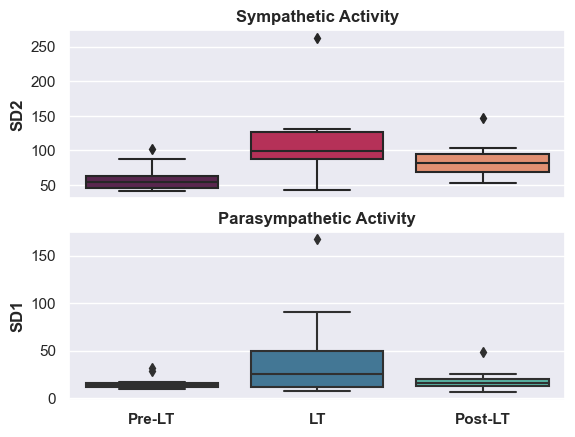

In [104]:
# SD1 correlates with the short-term variability of heart rate and is mainly influenced by parasympathetic modulation,
# whereas SD2 is a measure of long-term variability

sns.set()
plt.tight_layout
fig, ax = plt.subplots(2,1, sharex=True)
sns.boxplot([hrv_a['HRV_SD2'],hrv_b['HRV_SD2'],hrv_c['HRV_SD2']], ax=ax[0], palette='rocket')
sns.boxplot([hrv_a['HRV_SD1'],hrv_b['HRV_SD1'],hrv_c['HRV_SD1']], ax=ax[1], palette= 'mako')

ax[0].set_ylabel('SD2', weight = 'bold')
ax[0].set_title('Sympathetic Activity', weight = 'bold')
ax[1].set_ylabel('SD1', weight = 'bold')
ax[1].set_title('Parasympathetic Activity', weight = 'bold')

ax[1].set_xticks([0,1,2],['Pre-LT', 'LT', 'Post-LT'], weight = 'bold')
plt.show()

,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,31.591824,101.841705,0.310205,10107.651099,3.223673,4.71162,1313.217336,0.355505,0.329327,0.379562,...,1.258824,6.049158,0.94192,1.617887,1.427696,2.18266,1.71064,1.616476,3.605503,0.78431


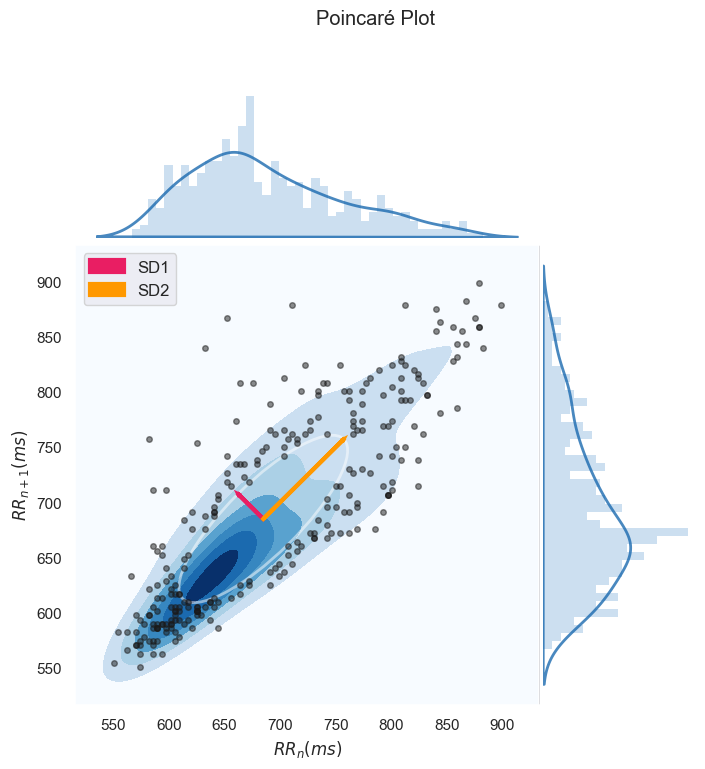

In [101]:
n=0
rr = nk.ecg_clean(A[n][:,q[n]], sampling_rate=fs, method='neurokit')
_, rr = nk.ecg_peaks(rr, sampling_rate=fs, method='neurokit', correct_artifacts=True)
nk.hrv_nonlinear(rr, sampling_rate=256, show=True)

,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,42.963805,180.821978,0.237603,24406.405455,4.208705,5.094474,3044.105414,0.558714,0.51058,0.8,...,0.175695,6.084598,0.303452,0.367554,0.802742,0.721594,0.530234,1.489686,1.708144,0.240784


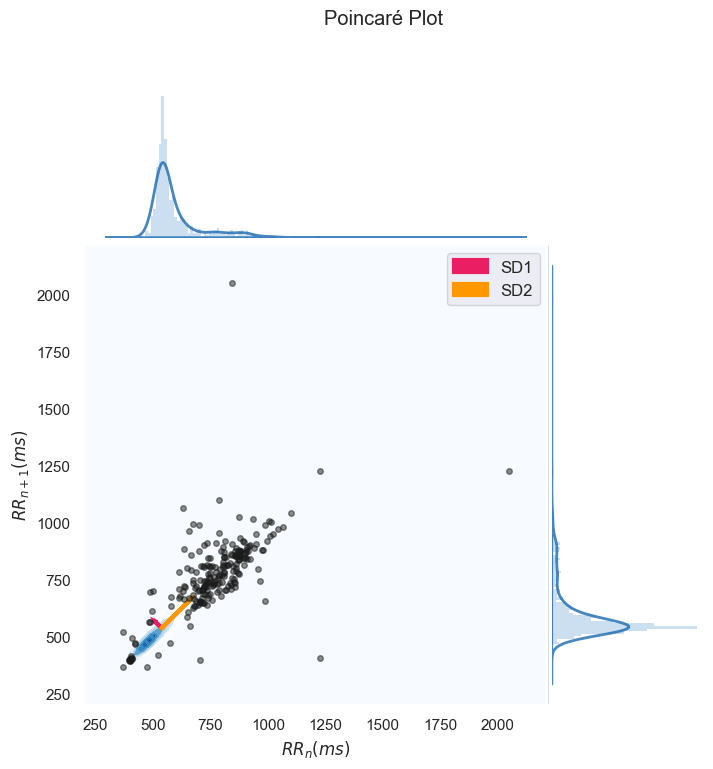

In [102]:
n=0
rr = nk.ecg_clean(B[n][:,q[n]], sampling_rate=fs, method='neurokit')
_, rr = nk.ecg_peaks(rr, sampling_rate=fs, method='neurokit', correct_artifacts=True)
nk.hrv_nonlinear(rr, sampling_rate=256, show=True)

,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,48.608433,146.947677,0.330787,22440.070828,3.02309,5.057994,1776.944308,0.421717,0.390836,0.593103,...,1.152479,6.496874,0.856325,1.476071,1.313634,1.981102,1.509772,1.699821,2.151784,0.631948


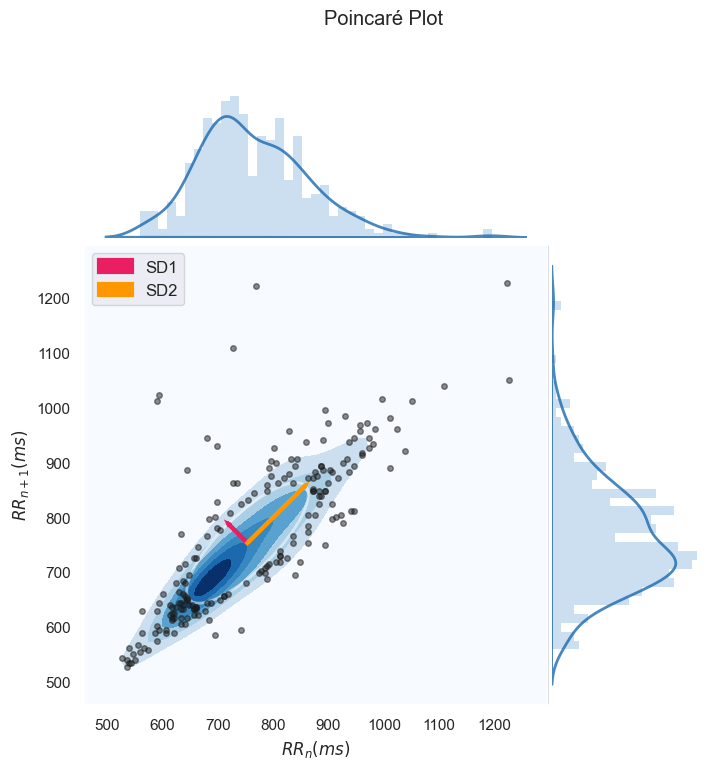

In [103]:
n=0
rr = nk.ecg_clean(C[n][:,q[n]], sampling_rate=fs, method='neurokit')
_, rr = nk.ecg_peaks(rr, sampling_rate=fs, method='neurokit', correct_artifacts=True)
nk.hrv_nonlinear(rr, sampling_rate=256, show=True)